In [1067]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1068]:
import os, sys
path = os.getcwd()
while not path.endswith('research'):    
    path = os.path.abspath(os.path.join(path, '../'))
sys.path.append(path)
sys.path.append('C:\git\statslib')
import statslib as stb
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [1069]:
import statsmodels.api as sm

In [1070]:
import numpy as np
from datetime import datetime, date
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import time
from copy import deepcopy
from pandas.tseries.offsets import DateOffset

In [1071]:
from gmt.fom.gas.shared.utils.common import *
from gmt.fom.gas.shared.utils.dframe import *

In [1072]:
from gmt.fom.gas.shared.models.stpb.data.mongo import MongoAdapter

In [1073]:
figsize=(9*1.6, 9)

In [1074]:
def save_to_path(f_name):
    _path = r'C:/git/gmt-fom-gas-research/sandbox/alexs/short_term_power_burn'
    return os.path.join(_path, f_name + '.csv')

In [1075]:
def get_fourier_series(timeIndex,K):
    m = 365.25
    d = 1
    fourier_series = pd.DataFrame({'date':timeIndex})
    fourier_series = fourier_series.set_index(pd.PeriodIndex(fourier_series['date'], freq='D'))
    for i in range(1, K+1):
        fourier_series[f'sin365_{i}'] = np.sin(2 * i * np.pi * d * fourier_series.index.dayofyear / m)
        fourier_series[f'cos365_{i}'] = np.cos(2 * i * np.pi * d * fourier_series.index.dayofyear / m)
    fourier_series = fourier_series.drop(columns=['date'])
    fourier_series.index = fourier_series.index.to_timestamp()
    return fourier_series

# CONSTANTS

In [1076]:
YEARS = 3

In [1077]:
FORECAST_HORIZON = 90

In [1078]:
R_DATA_PATH =  r'C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\R\data'

# DATA

In [1079]:
myData = MongoAdapter()
dataDM = myData.load_design_matrix()

t_out_time = dataDM.index[-FORECAST_HORIZON:].min(); t_out_time
t_out_sample = dataDM.index[-2*FORECAST_HORIZON:].min();  t_out_sample
t_start = t_out_time - DateOffset(years=YEARS)

mask = (dataDM.index>=t_start) & (dataDM.index<t_out_sample)
dataDM = dataDM[mask]


#removing leap year for 365 exactly
# leap_year_index = dataDM[(dataDM.index.month==2) & (dataDM.index.day==29)].index; leap_year_index
# dataDM = dataDM[~dataDM.index.isin(leap_year_index)]

#adding trend explicitely
dataDM['trend'] = range(1, len(dataDM.index)+1)

# monday_thursday vs. the rest
dataDM['weekday'] = dataDM.index.weekday
dataDM['weekday'] = dataDM['weekday'].apply(lambda t: t+1)
dataDM = dataDM.join(pd.get_dummies(dataDM['weekday'], prefix='day'))
dataDM['monday_thursday'] = dataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
dataDM = dataDM.join(pd.get_dummies(dataDM['monday_thursday'], prefix='mo_th'))

#fourier series
K = 3
dataDM = dataDM.join(get_fourier_series(dataDM.index,K))

In [1080]:
(dataDM.index.min(), dataDM.index.max())

(Timestamp('2017-11-17 00:00:00'), Timestamp('2020-08-18 00:00:00'))

In [1081]:
ddff(dataDM.head())

clean_spreads  curve_103234271  curve_103234272  curve_103234276  \
day                                                                            
2017-11-17       5.281861        25.270000        10.499091              9.0   
2017-11-18       5.281861        23.345454         9.597273              9.0   
2017-11-19       5.908723        23.897272        10.153636              9.0   
2017-11-20       4.989740        25.749091        10.153636              9.1   
2017-11-21       4.998985        26.410909        10.153636              9.1   

            curve_103234278  curve_103234281  dark_spreads        gas  \
day                                                                     
2017-11-17         7.163636        25.709091     -0.391730  64.676675   
2017-11-18         7.163636        25.709091     -0.391730  57.717558   
2017-11-19         7.163636        25.709091      1.254521  64.696082   
2017-11-20         7.163636        25.709091      0.584085  68.649516   
2017-11-21         7.163636        25.709091      1.202515  58.929583   

              precip  temperature  wind  trend  weekday  day_1  day_2  day_3  \
day                                                                            
2017-11-17  1.346667     5.200000  3.03      1        5      0      0      0   
2017-11-18  1.173333     6.031818  3.63      2        6      0      0      0   
2017-11-19  1.826667     4.745455  2.09      3        7      0      0      0   
2017-11-20  3.346667     8.436364  3.17      4        1      1      0      0   
2017-11-21  5.560000    11.213636  4.23      5        2      0      1      0   

            day_4  day_5  day_6  day_7 monday_thursday  mo_th_no  mo_th_yes  \
day                                                                           
2017-11-17      0      1      0      0              no         1          0   
2017-11-18      0      0      1      0              no         1          0   
2017-11-19      0      0      0      1              no         1          0   
2017-11-20      0      0      0      0             yes         0          1   
2017-11-21      0      0      0      0             yes         0          1   

            sin365_1  cos365_1  sin365_2  cos365_2  sin365_3  cos365_3  
day                                                                     
2017-11-17 -0.689796  0.724004 -0.998830  0.048363 -0.756517 -0.653974  
2017-11-18 -0.677240  0.735762 -0.996575  0.082692 -0.789245 -0.614079  
2017-11-19 -0.664483  0.747303 -0.993141  0.116923 -0.819871 -0.572548  
2017-11-20 -0.651530  0.758623 -0.988531  0.151016 -0.848314 -0.529494  
2017-11-21 -0.638384  0.769718 -0.982752  0.184931 -0.874498 -0.485029

In [1082]:
dependent_var = ['gas']; dependent_var

['gas']

In [1083]:
covariates = ['clean_spreads', 'dark_spreads', 'precip', 'temperature', 'wind', 'trend',
             'curve_103234271','curve_103234272','curve_103234276','curve_103234278','curve_103234281']; '| '.join(covariates)

'clean_spreads| dark_spreads| precip| temperature| wind| trend| curve_103234271| curve_103234272| curve_103234276| curve_103234278| curve_103234281'

In [1084]:
fourier_cols =  [k for k in dataDM if k.startswith('sin') or k.startswith('cos')]; '| '.join(fourier_cols)

'sin365_1| cos365_1| sin365_2| cos365_2| sin365_3| cos365_3'

In [1085]:
days_cols = [v for v in dataDM.columns if v.startswith('day_')]; '| '.join(days_cols)

'day_1| day_2| day_3| day_4| day_5| day_6| day_7'

In [1086]:
categorical_cols = [v for v in dataDM.columns if v.startswith('mo_')]; '| '.join(categorical_cols)

'mo_th_no| mo_th_yes'

In [1087]:
aux_cols = ['monday_thursday', 'weekday']; aux_cols

['monday_thursday', 'weekday']

In [1088]:
assert sorted(dependent_var + covariates + fourier_cols + days_cols + categorical_cols + aux_cols) == sorted(dataDM.columns)

In [1089]:
# categorical: remove the last level
try:
    days_cols.remove('day_7')
    categorical_cols.remove('mo_th_no')
except Exception as e:
    print(e.args[0])
    pass

# Design Matrix

In [1090]:
y = dataDM[dependent_var]; f = stb.transforms.identical(); y.head(1)

gas
day                  
2017-11-17  64.676675

In [1091]:
stb.stat_tests.test_kpss(f(y))

H0: observable time series is stationary around a constant

Results of KPSS Test:
Test Statistic            1.321822
p-value                   0.010000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Can NOT reject H0


In [1092]:
stb.stat_tests.test_adf(f(y))

H0: unit root present in the time series

Results of Dickey-Fuller Test:
Test Statistic                  -3.444981
p-value                          0.009518
#Lags Used                      21.000000
Number of Observations Used    984.000000
Critical Value (1%)             -3.437013
Critical Value (5%)             -2.864482
Critical Value (10%)            -2.568336
dtype: float64

p-value 0.0095 is less alpha 0.01 => Reject H0


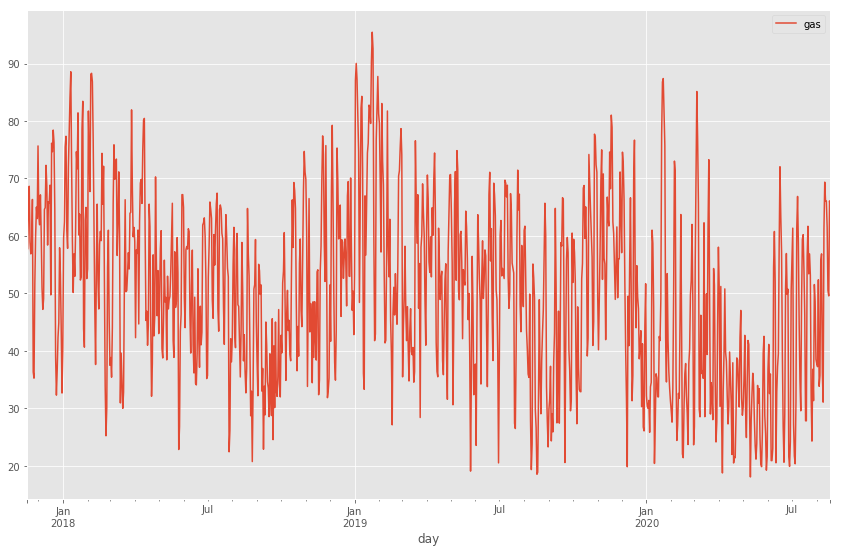

In [1093]:
fig, ax = plt.subplots(figsize=figsize)
y.plot(ax=ax)
plt.savefig(r'C:\temp\{}.png'.format('DependentVariable'), bbox_inches = 'tight', pad_inches = 0)

***

In [1094]:
gs = dict()

In [1095]:
g1 = stb.transforms.identical(); gs.update(dict(zip(covariates, [g1]*len(covariates))))

In [1096]:
g2 = stb.transforms.identical(); 
gs.update(dict(zip(categorical_cols, [g2]*len(categorical_cols))))

In [1097]:
gs.update(dict(trend=stb.transforms.identical()))

In [1098]:
X = dataDM[covariates + categorical_cols]; X.head(2)

clean_spreads  dark_spreads    precip  temperature  wind  trend  \
day                                                                           
2017-11-17       5.281861      -0.39173  1.346667     5.200000  3.03      1   
2017-11-18       5.281861      -0.39173  1.173333     6.031818  3.63      2   

            curve_103234271  curve_103234272  curve_103234276  \
day                                                             
2017-11-17        25.270000        10.499091              9.0   
2017-11-18        23.345454         9.597273              9.0   

            curve_103234278  curve_103234281  mo_th_yes  
day                                                      
2017-11-17         7.163636        25.709091          0  
2017-11-18         7.163636        25.709091          0

In [1099]:
DM = stb.DesignMatrix(y=y, X=X, f=f, gs=gs, add_const=True)

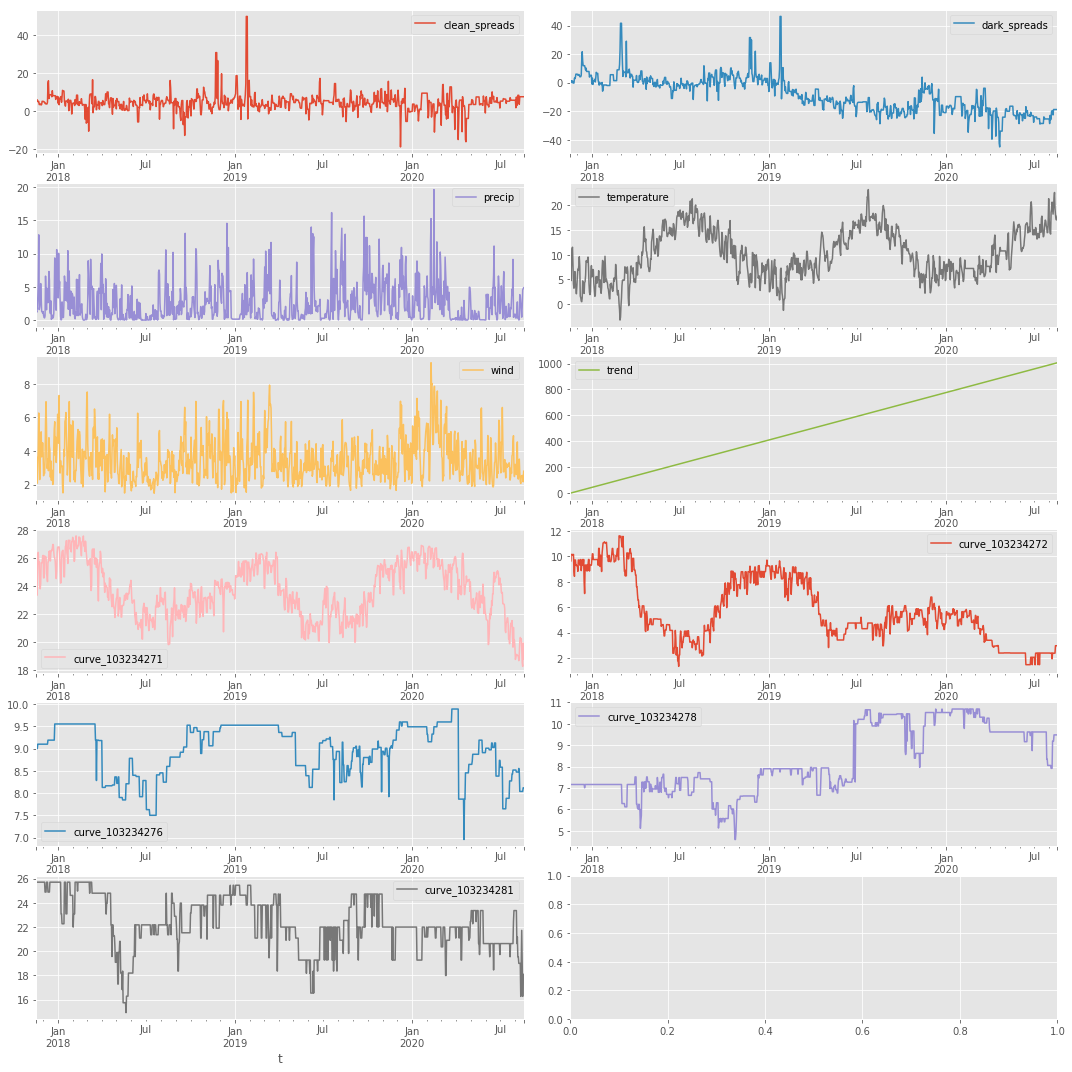

In [1100]:
DM.plot(only_names=covariates)

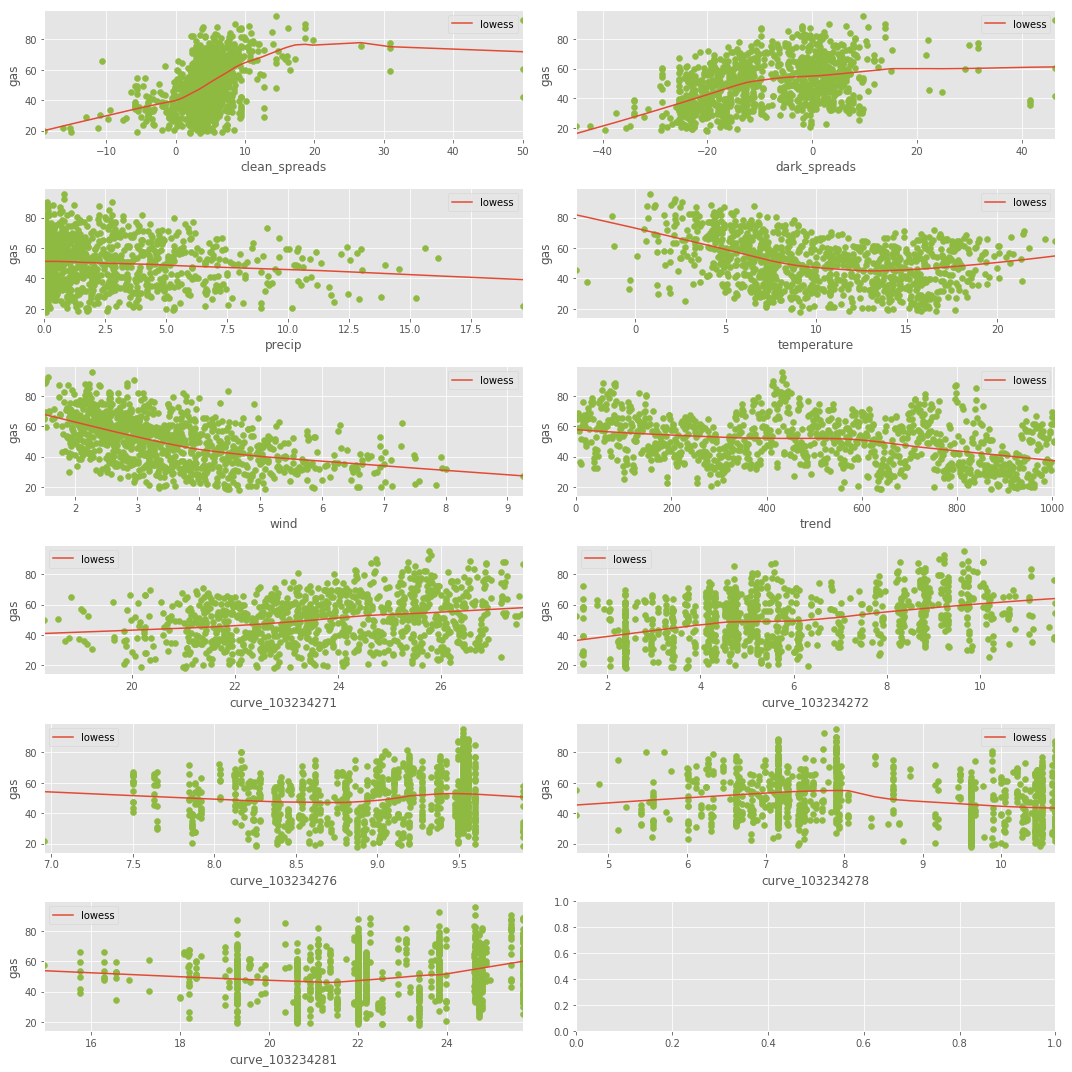

In [1101]:
DM.plot_scatter_lowess(drop_names=categorical_cols + fourier_cols)

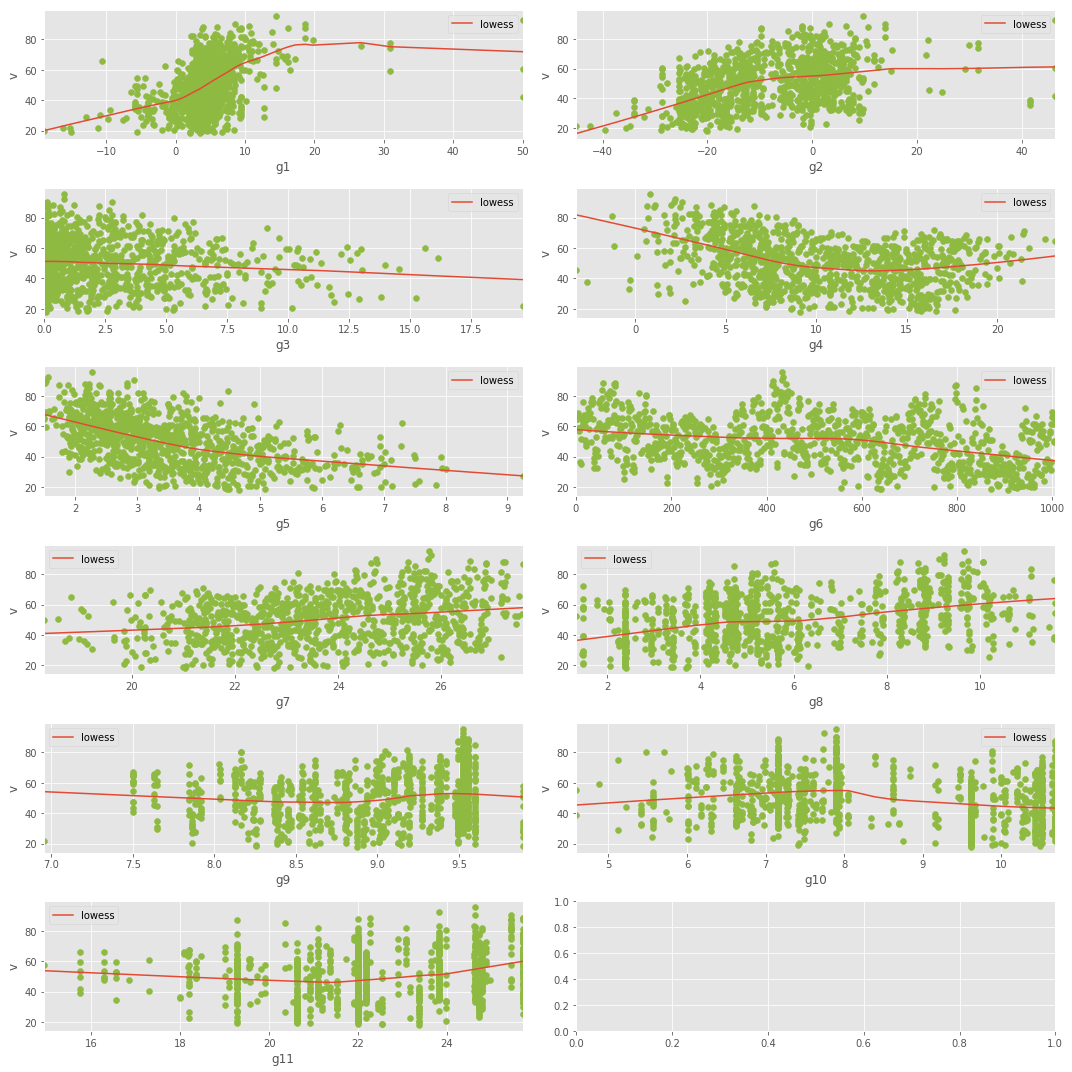

In [1102]:
DM.plot_scatter_lowess(drop_names=categorical_cols + fourier_cols, g_form=True)

## Exog specification <- grid search

In [1103]:
specification = list(map(DM._inv_names.get, [
     'const',
     'dark_spreads',
     'precip',
     'temperature',
      'wind',
     ]));

specification

['const', 'g2', 'g3', 'g4', 'g5']

In [1104]:
specification = DM.g_to_x(specification);specification

['const', 'dark_spreads', 'precip', 'temperature', 'wind']

In [1105]:
DM._inv_names.values()

dict_values(['v', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'g9', 'g10', 'g11', 'g12', 'const'])

In [1106]:
DM.x_to_g(specification)

['const', 'g2', 'g3', 'g4', 'g5']

In [1107]:
specification

['const', 'dark_spreads', 'precip', 'temperature', 'wind']

In [1108]:
DM.g_to_x(DM.x_to_g(specification))

['const', 'dark_spreads', 'precip', 'temperature', 'wind']

In [1109]:
DM.x_to_g(DM.x_to_g(specification))

['const', 'g2', 'g3', 'g4', 'g5']

In [1110]:
DM.x_to_g(DM.g_to_x(specification))

['const', 'g2', 'g3', 'g4', 'g5']

In [1111]:
DM.g_to_x(DM.g_to_x(specification))

['const', 'dark_spreads', 'precip', 'temperature', 'wind']

## AR(I)MA Grid Search

# Cross-validation

In [1112]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=6, test_size=FORECAST_HORIZON)
splits = [(train_idx, test_idx) for train_idx, test_idx in tscv.split(DM.dm.index)]

In [1113]:
metric = stb.metrics.root_mean_squared_error

## Grid Search

In [1114]:
gc = stb.GeneralCalibrator(sm.tsa.statespace.SARIMAX, 
                               dict(order=(1,0,1), 
                               trend='n', 
                               enforce_stationarity=True,
                               seasonal_order=(1, 0, 1, 7)))
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
cv = stb.CrossValidation(gm, splits, metric=metric)
cv_m, cv_std = cv.run(False)

y_range = nDM.y.max() - nDM.y.min();
print(f'CV_error/range: {cv_m/y_range*100:.2f}% | (range: {y_range:.0f})')

CV_error: 10.37, CV_std: 2.41 | (7.96  12.78)
CV_error/range: 13.41% | (range: 77)


## In sample

In [1115]:
specification

['const', 'dark_spreads', 'precip', 'temperature', 'wind']

                                     SARIMAX Results                                     
Dep. Variable:                                 v   No. Observations:                 1006
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3390.572
Date:                           Sat, 24 Apr 2021   AIC                           6801.144
Time:                                   06:56:35   BIC                           6850.282
Sample:                               11-17-2017   HQIC                          6819.815
                                    - 08-18-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.1354     13.388      5.985      0.000      53.895     106.376
g2             0.1524      0.036      4.240

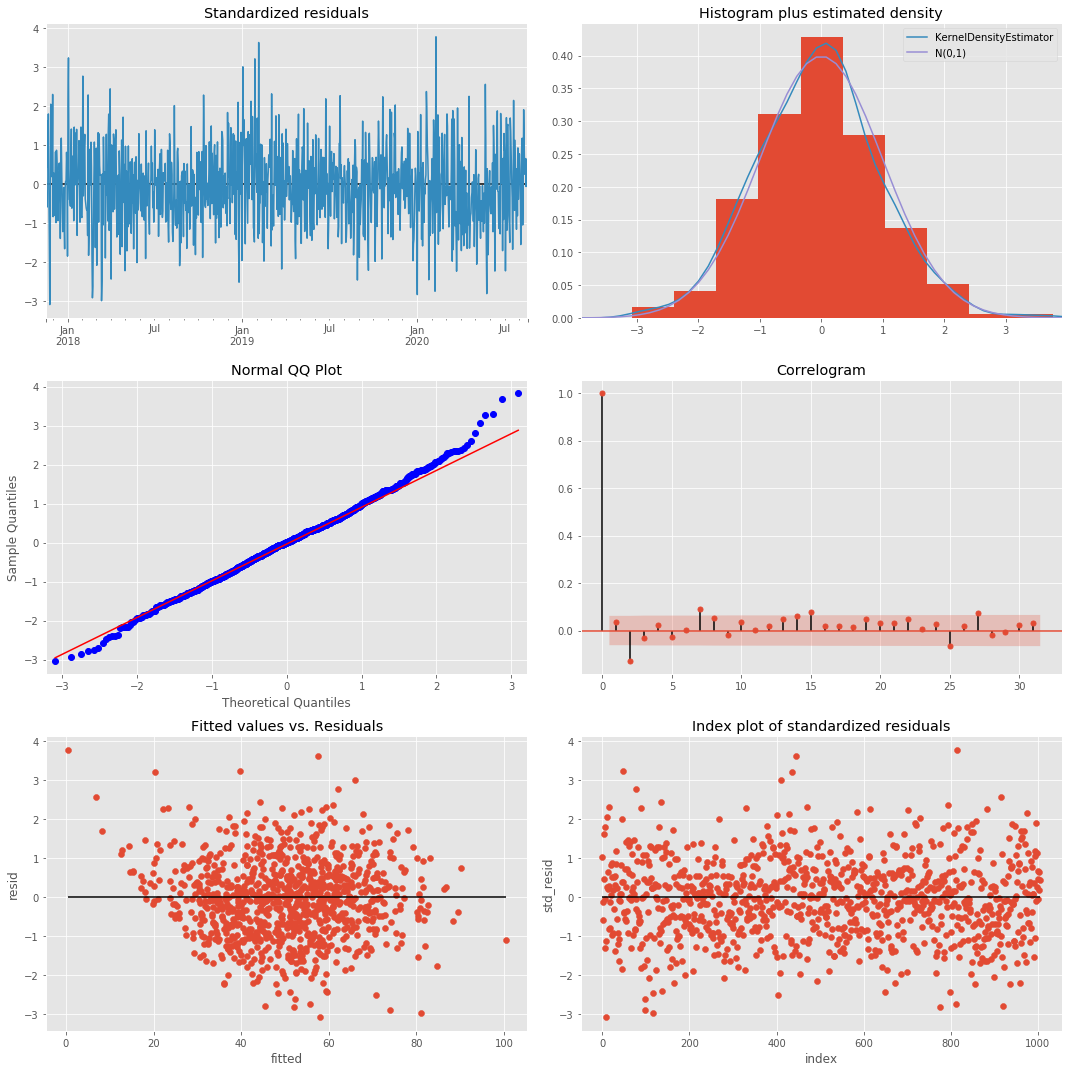

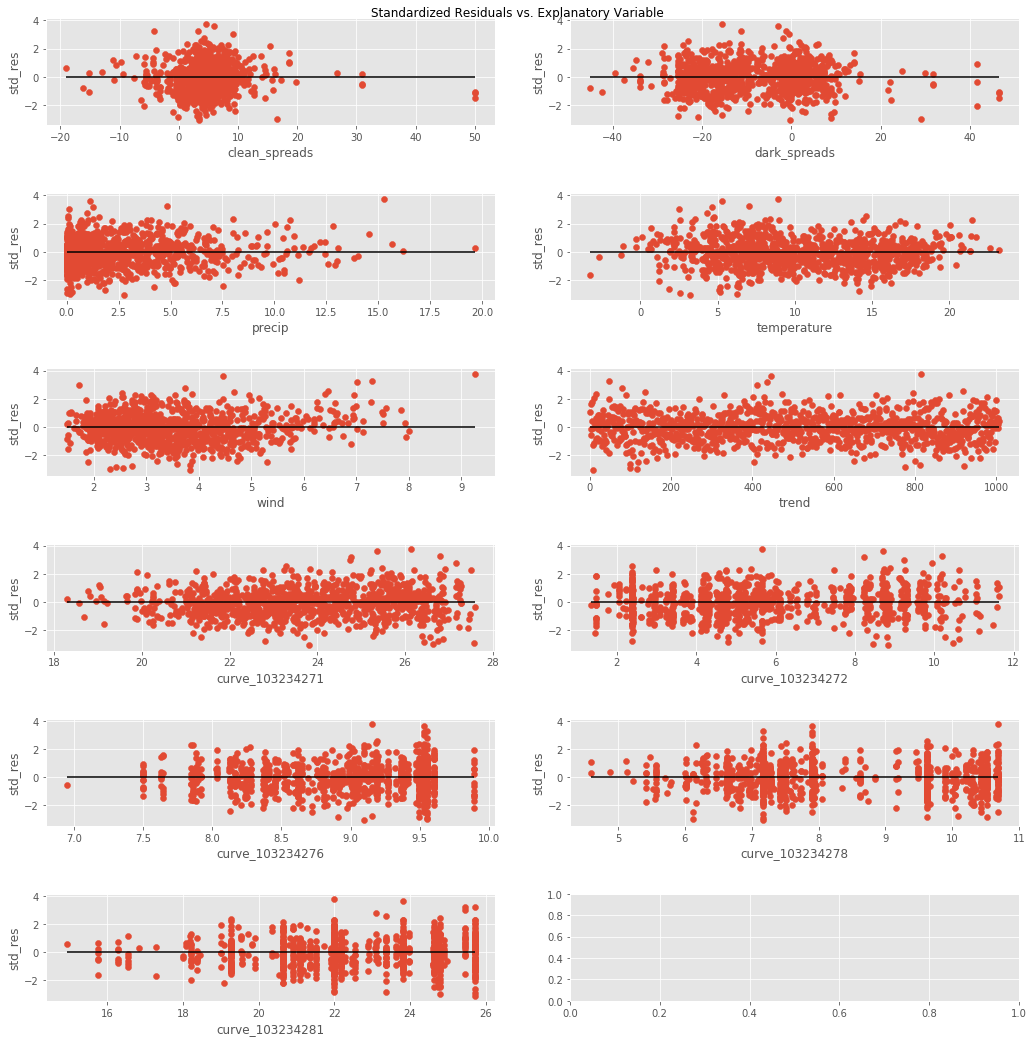

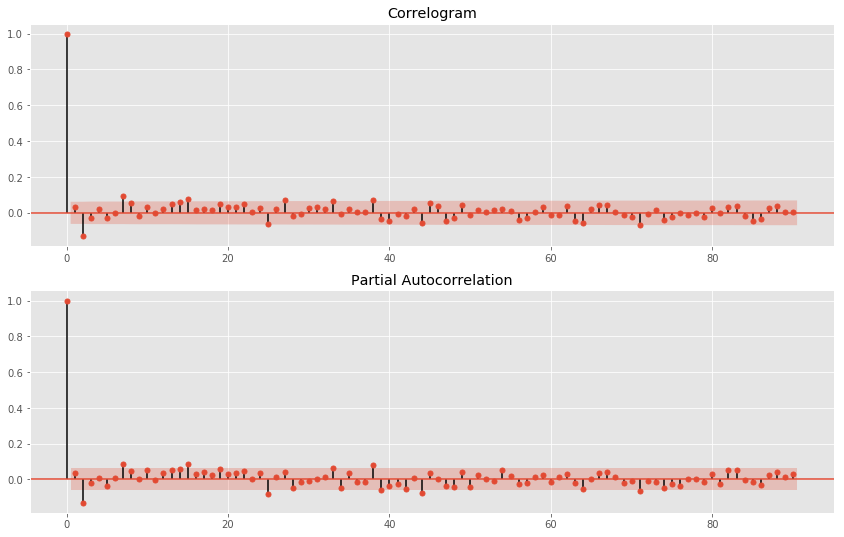

In [1116]:
nDM = deepcopy(DM)
nDM.gX = nDM.gX[DM.x_to_g(specification)]
gm = stb.GeneralModel(gc, nDM)
gm.fit(range(DM.n))
gm.forecast(range(DM.n))
print(gm.fitted.summary())
gm.plot_diagnostics(drop_names=categorical_cols+fourier_cols)
stb.stat_plots.plot_acf_pcf(gm.std_residuals, kwargs_acf={'lags': 90}, kwargs_pacf={'lags':90})

NOBS = gm.fitted.nobs

Error: 7.04


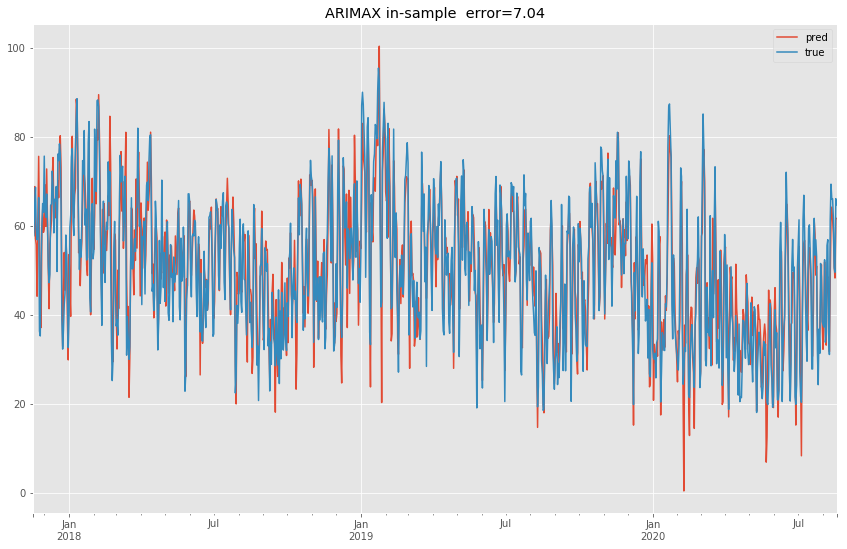

In [1117]:
exog = DM.gX[DM.x_to_g(specification)]
v_hat = gm.fitted.predict(start=exog.index.min(), 
                          end=exog.index.max(), 
                          exog=exog)
y_hat = DM.f.inv(v_hat, y0=DM.dm.y[DM.dm.index.max()])
in_sample_error = metric(DM.y.loc[y_hat.index], y_hat)
print(f'Error: {in_sample_error:.2f}')

fig, ax = plt.subplots(figsize=figsize)
y_hat.plot(ax=ax)
DM.y.loc[y_hat.index].plot(ax=ax)
ax.legend(['pred', 'true', 'hist'])
title = f'ARIMAX in-sample  error={in_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()

## Out of sample

In [1118]:
data = myData.load_design_matrix()

outDataDM = deepcopy(data[(data.index>=t_out_sample) & (data.index<t_out_time)]);

outY = outDataDM[dependent_var]

#adding trend explicitely
outDataDM['trend'] = range(1, len(outDataDM.index)+1)

# monday_thursday vs. the rest
outDataDM['weekday'] = outDataDM.index.weekday
outDataDM['weekday'] = outDataDM['weekday'].apply(lambda t: t+1)
outDataDM = outDataDM.join(pd.get_dummies(outDataDM['weekday'], prefix='day'))
outDataDM['monday_thursday'] = outDataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
outDataDM = outDataDM.join(pd.get_dummies(outDataDM['monday_thursday'], prefix='mo_th'))

#fourier series
outDataDM = outDataDM.join(get_fourier_series(outDataDM.index, K))

outX = outDataDM[covariates + categorical_cols]; #outX.head(2)

outDM = stb.DesignMatrix(y=outY, X=outX, f=DM.f, gs=DM.gs, add_const=True)


gm.fitted.params.to_frame().T.rename(columns=DM.names).T

0
const         80.135443
dark_spreads   0.152389
precip         0.178158
temperature   -0.535433
wind          -6.647484
ar.L1          0.837407
ma.L1         -0.262438
ar.S.L7        0.999053
ma.S.L7       -0.961800
sigma2        48.706336

***

In [1119]:
DM.x_to_g(specification)

['const', 'g2', 'g3', 'g4', 'g5']

In [1120]:
outDM.x_to_g(specification)

['const', 'g2', 'g3', 'g4', 'g5']

Error: 7.27


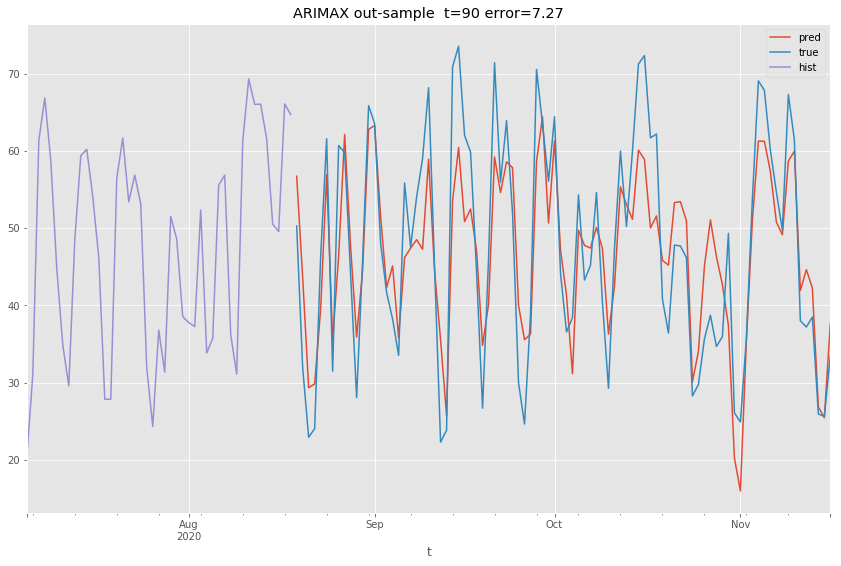

In [1121]:
exog = outDM.gX[outDM.x_to_g(specification)]
v_hat = gm.fitted.predict(start=exog.index.min(), 
                          end=exog.index.max(), 
                          exog=exog)
y_hat = DM.f.inv(v_hat, y0=DM.dm.y[DM.dm.index.max()])
out_of_sample_error = metric(outDM.y.loc[y_hat.index], y_hat)
print(f'Error: {out_of_sample_error:.2f}')

fig, ax = plt.subplots(figsize=figsize)
y_hat.plot(ax=ax)
outDM.y.loc[y_hat.index].plot(ax=ax)
DM.dm.y[-int(FORECAST_HORIZON/2):].plot(ax=ax)
ax.legend(['pred', 'true', 'hist'])
title = f'ARIMAX out-sample  t={FORECAST_HORIZON} error={out_of_sample_error:.2f}'
ax.set_title(title)
plt.savefig(r'C:\temp\{}.png'.format(title), bbox_inches = 'tight', pad_inches = 0)
plt.show()

# Out of time

In [1122]:
data = myData.load_design_matrix()

outTimeDataDM = deepcopy(data[int(-NOBS-FORECAST_HORIZON):])

outTimeY = outTimeDataDM[dependent_var]

#adding trend explicitely
outTimeDataDM['trend'] = range(1, len(outTimeDataDM.index)+1)

# monday_thursday vs. the rest
outTimeDataDM['weekday'] = outTimeDataDM.index.weekday
outTimeDataDM['weekday'] = outTimeDataDM['weekday'].apply(lambda t: t+1)
outTimeDataDM = outTimeDataDM.join(pd.get_dummies(outTimeDataDM['weekday'], prefix='day'))
outTimeDataDM['monday_thursday'] = outTimeDataDM['weekday'].apply(lambda v: 'yes' if v>=1 and v<5 else 'no')
outTimeDataDM = outTimeDataDM.join(pd.get_dummies(outTimeDataDM['monday_thursday'], prefix='mo_th'))

#fourier series
outTimeDataDM = outTimeDataDM.join(get_fourier_series(outTimeDataDM.index, K))

ddff(outTimeDataDM.head())

outX = outTimeDataDM[covariates + categorical_cols]; outX.head(2)

outTimeDM = stb.DesignMatrix(y=outTimeY, X=outX, f=f, gs=gs, add_const=True)

# ddff(outTimeDM.dm.head(2))

clean_spreads  curve_103234271  curve_103234272  curve_103234276  \
day                                                                            
2018-02-15       4.046223        27.445454        10.138182         9.554545   
2018-02-16       4.046223        26.898182         9.562727         9.554545   
2018-02-17       4.046223        26.601818         9.610000         9.554545   
2018-02-18       6.529748        26.170000         9.650909         9.554545   
2018-02-19       4.375822        27.154545         9.650909         9.554545   

            curve_103234278  curve_103234281  dark_spreads        gas  \
day                                                                     
2018-02-15         7.163636        25.709091       1.41325  47.294989   
2018-02-16         7.163636        25.709091       1.41325  58.501659   
2018-02-17         7.163636        25.709091       1.41325  60.792909   
2018-02-18         7.163636        25.709091       1.41325  59.184069   
2018-02-19         7.163636        25.709091       1.41325  74.377294   

              precip  temperature  wind  trend  weekday  day_1  day_2  day_3  \
day                                                                            
2018-02-15  0.733333     5.245455  4.94      1        4      0      0      0   
2018-02-16  1.000000     4.609091  3.27      2        5      0      0      0   
2018-02-17  1.226667     5.359091  2.70      3        6      0      0      0   
2018-02-18  2.426667     5.154545  2.07      4        7      0      0      0   
2018-02-19  2.440000     8.036364  2.48      5        1      1      0      0   

            day_4  day_5  day_6  day_7 monday_thursday  mo_th_no  mo_th_yes  \
day                                                                           
2018-02-15      1      0      0      0             yes         0          1   
2018-02-16      0      1      0      0              no         1          0   
2018-02-17      0      0      1      0              no         1          0   
2018-02-18      0      0      0      1              no         1          0   
2018-02-19      0      0      0      0             yes         0          1   

            sin365_1  cos365_1  sin365_2  cos365_2  sin365_3  cos365_3  
day                                                                     
2018-02-15  0.711276  0.702913  0.999930 -0.011826  0.694452 -0.719539  
2018-02-16  0.723262  0.690574  0.998932 -0.046215  0.656411 -0.754404  
2018-02-17  0.735034  0.678031  0.996751 -0.080549  0.616621 -0.787260  
2018-02-18  0.746588  0.665287  0.993390 -0.114788  0.575190 -0.818020  
2018-02-19  0.757922  0.652346  0.988854 -0.148890  0.532227 -0.846602

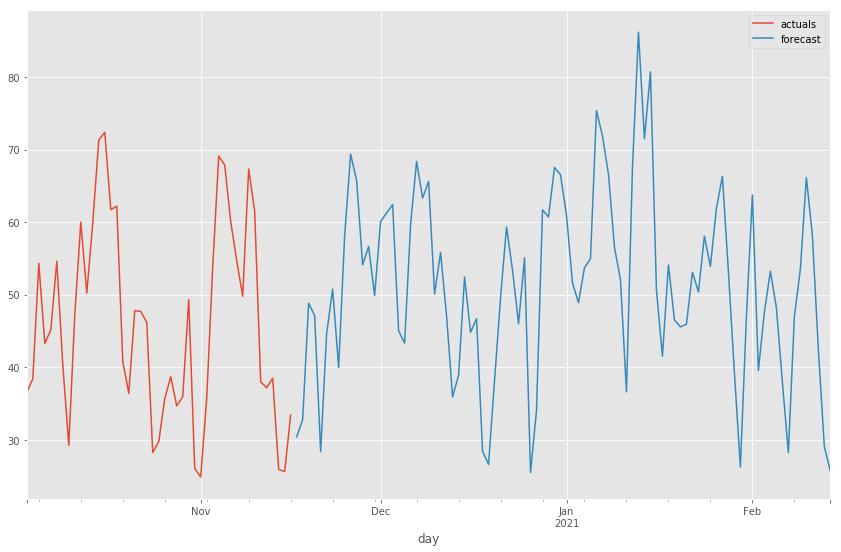

In [1123]:
nDM = deepcopy(outTimeDM)
nDM.gX = nDM.gX[outTimeDM.x_to_g(specification)].rename(columns=outTimeDM.names)
gm = stb.GeneralModel(gc, nDM)
gm.fit(range(outTimeDM.n-FORECAST_HORIZON))

gm.forecast(range(outTimeDM.n-FORECAST_HORIZON, outTimeDM.n))

v_hat = gm.v_hat
y_hat = gm.y_hat

fig, ax = plt.subplots(figsize=figsize)
data.gas.iloc[:-(FORECAST_HORIZON)].iloc[-int(FORECAST_HORIZON/2):].plot(ax=ax)
y_hat.plot(ax=ax)
ax.legend(['actuals', 'forecast'])
plt.show()

In [1124]:
print(gm.fitted.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 v   No. Observations:                 1006
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -3380.804
Date:                           Sat, 24 Apr 2021   AIC                           6781.608
Time:                                   06:56:48   BIC                           6830.745
Sample:                               02-15-2018   HQIC                          6800.278
                                    - 11-16-2020                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           79.7499      7.514     10.614      0.000      65.023      94.477
dark_spreads     0.1286      0.038   

## Benchmark from PointValue

# SUMMARY

In [1125]:
path = r'C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\results'
cfn = stb.utils.file.create_file_name

summary_dict = dict(zip(['YEARS',
'FORECAST_HORIZON',
'cv_m',
'cv_std',
'in_sample_error',
'out_of_sample_error'],
[YEARS,
FORECAST_HORIZON,
round(cv_m,2),
round(cv_std,4),
round(in_sample_error, 4),
round(out_of_sample_error,2)]))
summary_dict.update(dict(zip(specification, DM.g_to_x(specification))))
summary_dict.update(dict(cf=gc.cf.__name__))
transforms_dict = {k:v.__str__().split('transforms.')[1].split(' ')[0] for k,v in gs.items()}
summary_dict.update(dict(gs=transforms_dict))
summary_dict
pd.DataFrame.from_dict(summary_dict, orient='index').T.to_json(cfn(folder=path, extension='json', silent=False))

Saved to C:\git\gmt-fom-gas-research\sandbox\alexs\short_term_power_burn\results\results_2021_04_24_06_56_48.json


In [1127]:
mySmartData = stb.SmartData()
mySmartData.acquire.from_folder(path)
mask = ['FORECAST_HORIZON', 'YEARS', 'cf', 'cv_m', 'cv_std', 'in_sample_error', 'out_of_sample_error' ]
pd.concat([mySmartData.get(name) for name in mySmartData.sourced.names]).reset_index(drop=True).sort_index(ascending=False)[mask].head(6)

FORECAST_HORIZON  YEARS       cf   cv_m  cv_std  in_sample_error  \
132                90      3  SARIMAX  10.37  2.4105           7.0443   
131                28      3  SARIMAX   8.44  1.7125           7.0256   
130                14      3  SARIMAX   8.54  2.7348           7.0337   
129                90      3  SARIMAX  10.41  2.5929           7.0293   
128                28      3  SARIMAX   8.58  1.7547           7.0198   
127                14      3  SARIMAX   8.71   2.856           7.0322   

     out_of_sample_error  
132                 7.27  
131                 9.63  
130                 9.89  
129                 7.55  
128                10.06  
127                 9.50